# Lung Cancer Detection Using VGG16

Importing all the necessary libraries.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.cm as cm
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image

In [5]:
DIRECTORY = '../lung_colon_image_set/lung_image_sets'
categories = os.listdir(DIRECTORY)
categories.remove(".DS_Store")
print(categories)
class_no = len(categories)
print(class_no)
data = []
label = []

['lung_aca', 'lung_n', 'lung_scc']
3


Dataset consists of three folders. 'lung_aca' means lung Adenocarcinomas, 'lung_n' means Benign Lung Tissue, 'lung_scc' means Lung Squamous Cell Carcinomas.

Reading all the images and resizing the images to 64x64 pixels. And converting it into array.

In [6]:
for i, category in enumerate(categories):
    path = os.path.join(DIRECTORY, category)
    for k, img_name in enumerate(os.listdir(path)):
        img = cv2.imread(os.path.join(DIRECTORY, category, img_name))
        img = cv2.resize(img, (64, 64))
        img = np.array(img)
        data.append(img)
        label.append(i)

In [7]:
data = np.array(data, dtype=np.float32)
data.shape

(15000, 64, 64, 3)

In [8]:
label = np.array(label)
label.shape

(15000,)

Splitting our data in train, test and validation purpose. The percentage of training data is 70% and 15% each for testing and validation.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(10500, 64, 64, 3)
(10500,)
(2250, 64, 64, 3)
(2250,)
(2250, 64, 64, 3)
(2250,)


In [10]:
samples = []
for i in range(0, class_no):
    samples.append(len(np.where(y_train==i)[0]))

print(samples)

[3476, 3508, 3516]


Total number of images for each classes.

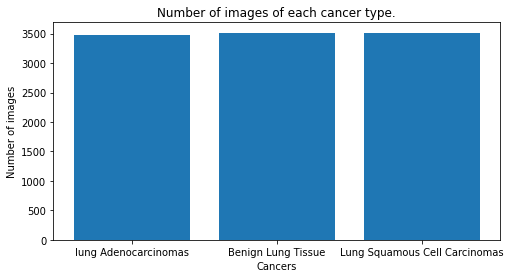

In [11]:
plt.figure(figsize=(8, 4))
plt.bar(['lung Adenocarcinomas', 'Benign Lung Tissue', 'Lung Squamous Cell Carcinomas'], samples)
plt.title("Number of images of each cancer type.")
plt.xlabel("Cancers")
plt.ylabel("Number of images")
plt.show()

In [12]:
samples = []
for i in range(0, class_no):
    samples.append(len(np.where(y_test==i)[0]))

print(samples)

[751, 751, 748]


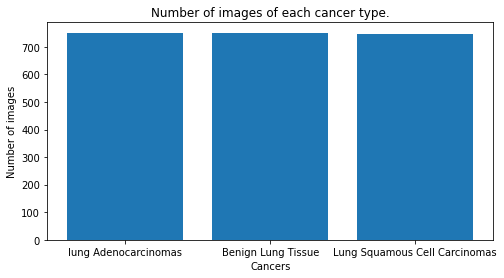

In [13]:
plt.figure(figsize=(8, 4))
plt.bar(['lung Adenocarcinomas', 'Benign Lung Tissue', 'Lung Squamous Cell Carcinomas'], samples)
plt.title("Number of images of each cancer type.")
plt.xlabel("Cancers")
plt.ylabel("Number of images")
plt.show()

In [14]:
samples = []
for i in range(0, class_no):
    samples.append(len(np.where(y_val==i)[0]))

print(samples)

[773, 741, 736]


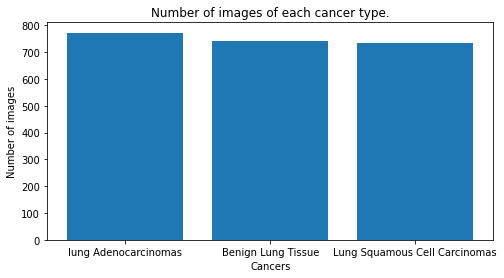

In [15]:
plt.figure(figsize=(8, 4))
plt.bar(['lung Adenocarcinomas', 'Benign Lung Tissue', 'Lung Squamous Cell Carcinomas'], samples)
plt.title("Number of images of each cancer type.")
plt.xlabel("Cancers")
plt.ylabel("Number of images")
plt.show()

Visualising a image from training data.

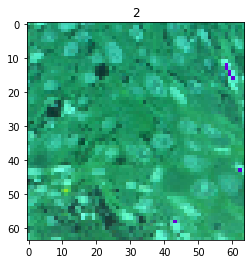

In [16]:
plt.imshow((x_train[0] * 255).astype(np.uint8))
plt.title(y_train[0])
plt.show()

# Model Arechitecture: VGG 16
VGG-16 is a convolution neural net (CNN) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date..... 

Importing vgg16 and declaring the input shape of model as 64x64 pixels as our images are of this size.

In [17]:
vgg = VGG16( input_shape=(64, 64, 3), include_top= False)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-16 02:37:03.974697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-16 02:37:03.975327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


58900480/58889256 [==============================] - 5s 0us/step


In [18]:
for layer in vgg.layers:         
  layer.trainable = False

In [19]:
x = Flatten()(vgg.output)
x = Dense(units=3 , activation='softmax', name = 'predictions' )(x)

model = Model(vgg.input, x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [21]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Implementing early stopping and model check point.

In [22]:
es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="lung cancer detection model.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

Training the model.

In [34]:
hist = model.fit(x_train, y_train, epochs=40, steps_per_epoch=15, validation_data=(x_val, y_val), callbacks=[es, mc])

Epoch 1/40


2022-10-16 14:01:56.412169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.9360
Epoch 1: val_accuracy did not improve from 0.91822
15/15 [==============================] - 24s 2s/step - loss: 0.2625 - accuracy: 0.9360 - val_loss: 0.4264 - val_accuracy: 0.9142
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.2298 - accuracy: 0.9430
Epoch 2: val_accuracy improved from 0.91822 to 0.91956, saving model to lung cancer detection model.h5
15/15 [==============================] - 23s 2s/step - loss: 0.2298 - accuracy: 0.9430 - val_loss: 0.3826 - val_accuracy: 0.9196
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9435
Epoch 3: val_accuracy did not improve from 0.91956
15/15 [==============================] - 22s 1s/step - loss: 0.2102 - accuracy: 0.9435 - val_loss: 0.3734 - val_accuracy: 0.9182
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9472
Epoch 4: val_accuracy improved from 0.91956

Loading the model

In [24]:
model = load_model("lung cancer detection model.h5")

In [25]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

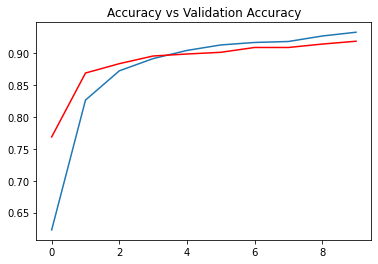

In [26]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("Accuracy vs Validation Accuracy")
plt.show()

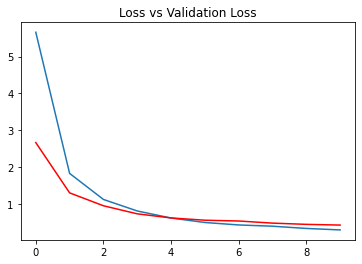

In [27]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("Loss vs Validation Loss")
plt.show()

Checking the accuracy.

In [35]:
acc = model.evaluate(x_test, y_test)[1] 

print(f"The accuracy of your model is = {acc} %")

71/71 [==============================] - 4s 53ms/step - loss: 0.3675 - accuracy: 0.9209
The accuracy of your model is = 0.9208889007568359 %


# The accuracy of the model is 93.47%.

# Grad Cam Visualisation

In [29]:
def get_img_array(img_path):
  path = img_path
  img = image.load_img(path, target_size=(64,64,3))
  img = image.img_to_array(img)/255
  img = np.expand_dims(img , axis= 0 )
  
  return img

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [31]:
def save_and_display_gradcam(img_path , heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

In [32]:
class_type = {0:'lung Adenocarcinomas', 1:'Benign Lung Tissue', 2:'Lung Squamous Cell Carcinomas'}
def image_prediction_and_visualization(path,last_conv_layer_name = "block5_conv3", model = model):
    
    img_array = get_img_array(path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    img = get_img_array(path)
    res = class_type[np.argmax(model.predict(img))]
    print(f"The given X-Ray image is of type = {res}")
    print()
    print(f"The chances of image being lung Adenocarcinomas is : {model.predict(img)[0][0]*100} %")
    print(f"The chances of image being Benign Lung Tissue is : {model.predict(img)[0][1]*100} %")
    print(f"The chances of image being Lung Squamous Cell Carcinomas is : {model.predict(img)[0][2]*100} %")
    print()
    print("Image with heatmap representing the tissue")
    save_and_display_gradcam(path, heatmap)
    print()
    print("The original input image")
    print()
    a = plt.imread(path)
    plt.imshow(a, cmap = "gray")
    plt.title("Original image")
    plt.show()

2022-10-16 13:04:02.468054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The given X-Ray image is of type = Benign Lung Tissue

The chances of image being lung Adenocarcinomas is : 35.15629768371582 %
The chances of image being Benign Lung Tissue is : 40.8835768699646 %
The chances of image being Lung Squamous Cell Carcinomas is : 23.96012842655182 %

Image with heatmap representing the tissue


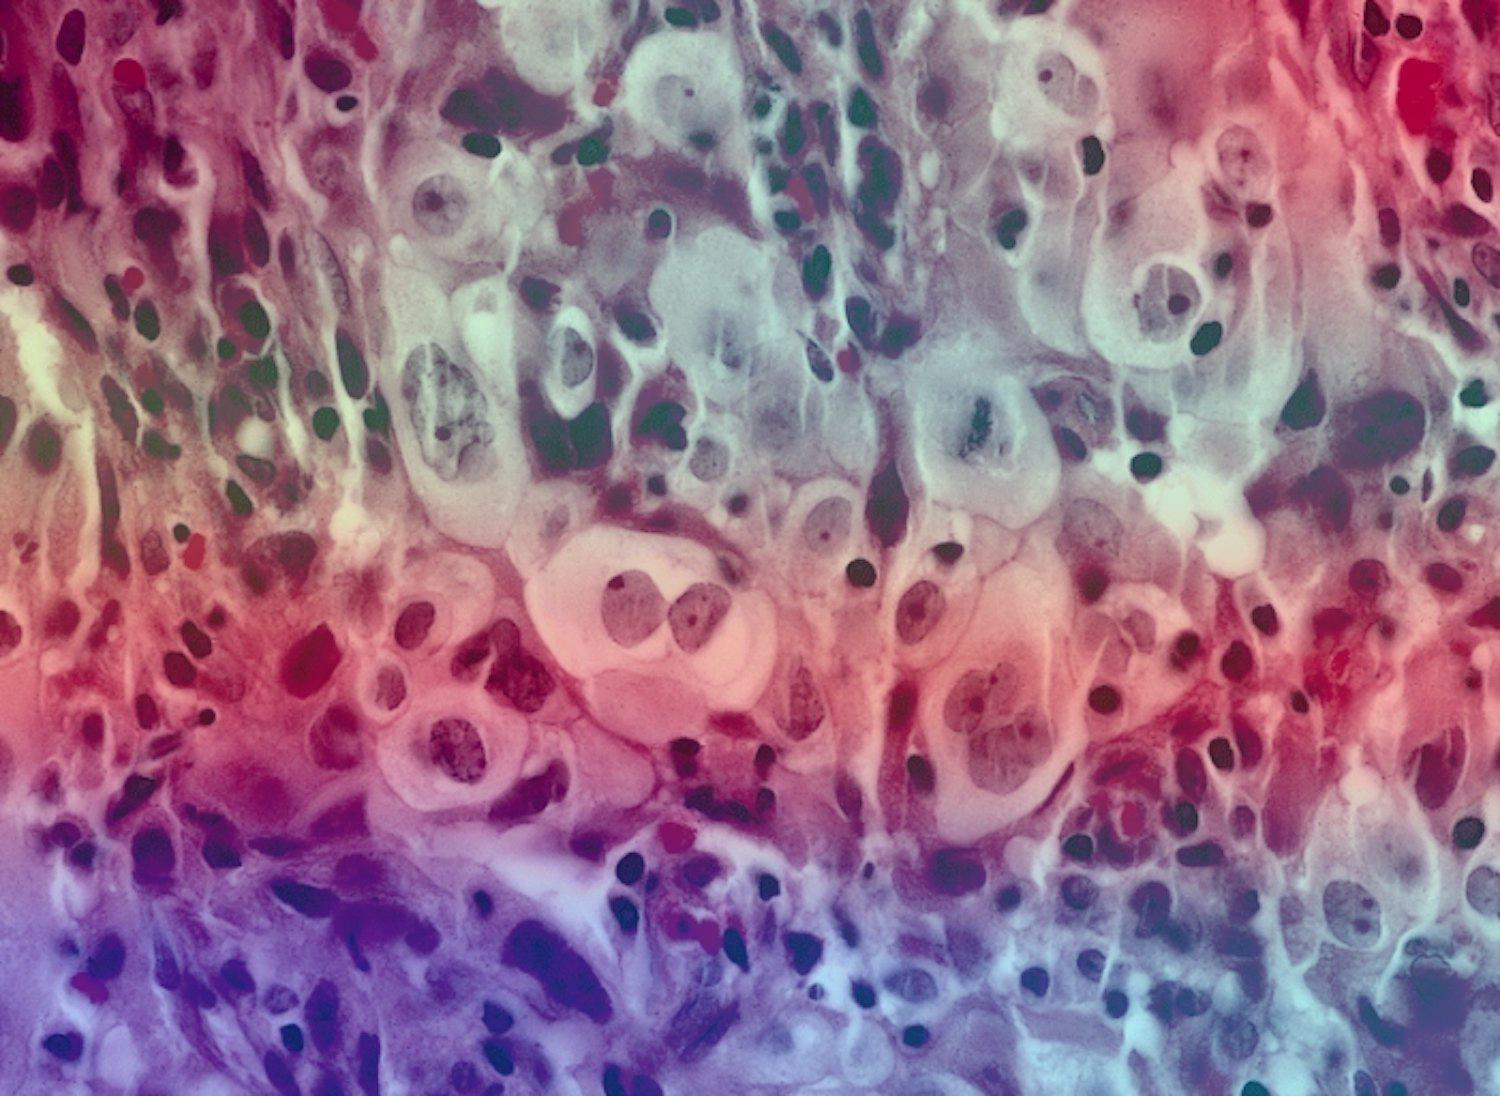


The original input image



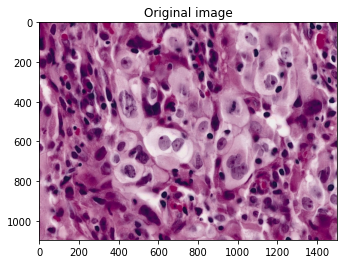

In [33]:
path = "test/5.jpg"

image_prediction_and_visualization(path)